# Hazard Extraction and Analysis of Trends (HEAT): ICS-209-PLUS

This notebook provides a demonstration of the hazard extraction and analysis of trends (HEAT) framework applied to the ICS-209-PLUS dataset, available at https://data.nal.usda.gov/dataset/data-all-hazards-dataset-mined-us-national-incident-management-system-1999%E2%80%932014 

This example uses the trend analysis module from MIKA's knowledge discovery toolkit, as well as the Data and ICS utilities.

Prior to performing the analysis in this notebook, hazards are extracted using BERTopic from topic model plus using the ICS_hazard_extraction_script.

## Imports

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.style
matplotlib.style.use("seaborn-v0_8")
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams["font.family"] = "Times New Roman"
import seaborn as sn
sn.color_palette("hls", 17)
import scipy.stats as st
import math
import dill
from pingouin import rcorr


In [2]:
import sys
import os
sys.path.append(os.path.join("..", "..", "..", ".."))

from mika.kd.trend_analysis import *
from mika.utils.ICS import *
from mika.utils import Data

For figure consistency, global configuration variables are defined here.

In [3]:
figsize = (6, 4)
fontsize = 14
matrix_figsize = (8,9)
matrix_fontsize = 10

## Data Import

The preprocessed ICS-209-PLUS dataset is loaded in using the Data utility

In [4]:
document_id_col = "Unique IDs"
extra_cols = ["CY","DISCOVERY_DATE", "START_YEAR", "REPORT_DOY", "DISCOVERY_DOY",
              "TOTAL_PERSONNEL", "TOTAL_AERIAL", "PCT_CONTAINED_COMPLETED"]
list_of_attributes = ["Combined Text"]
file = os.path.join('topic_model_results', 'preprocessed_data_combined_text.csv')
ICS = Data()
ICS.load(file, preprocessed=True, id_col=document_id_col, text_columns=["Combined Text"], preprocessed_kwargs={'drop_short_docs':False, 'drop_duplicates':True})

Now the preprocessed dataframe that will be used is defined:

In [5]:
preprocessed_df = ICS.data_df

The dataframe is then filtered to ensure it includes the correct years and incidents.

In [6]:
incident_file = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir, os.pardir)),'data','ICS','summary_reports_cleaned.csv')
incident_summary_df = pd.read_csv(incident_file,low_memory=False)
incident_summary_df = incident_summary_df.drop("Unnamed: 0", axis=1)
incident_summary_df = incident_summary_df.loc[incident_summary_df["START_YEAR"]>=2006].reset_index(drop=True)

fire_ids = incident_summary_df['INCIDENT_ID'].unique()
sitrep_ids = preprocessed_df['INCIDENT_ID'].unique()
incident_summary_df = incident_summary_df[incident_summary_df['INCIDENT_ID'].isin(sitrep_ids)].reset_index(drop=True)

## Hazard Extraction

First hazards are identified in documents using  BERTopic modeling results and a hazard interptretation spreed sheet created from the topics. 

The hazard file and topic modeling results file are specified here:

In [7]:
hazard_file =  os.path.join('topic_model_results','hazard_interpretation_v1.xlsx')
results_file = os.path.join('topic_model_results',"Combined Text Sentences_BERT_topics_modified.csv")

In [8]:
hazard_interpretation_df = pd.read_excel(hazard_file, sheet_name='topic-focused')
categories = hazard_interpretation_df['Hazard Category'].tolist()
hazards = hazard_interpretation_df['Hazard name'].tolist()

The hazard and results file are passed into the identify_docs_per_hazard function, which returns the frequency and documents associated with each hazard in addition to the hazard words and topics per each document. Hazard metrics specific to the ICS are calulcuated using calc_ICS_metrics:

In [9]:
# frequency, docs_per_hazard, hazard_words_per_doc, topics_per_doc, hazard_topics_per_doc = identify_docs_per_hazard(hazard_file, preprocessed_df, results_file, text_field='Combined Text', results_text_field='Combined Text Sentences_BERT_to', time_field="CY", id_field='Unique IDs', doc_topic_dist_field=None, topic_thresh=0.0)
# time_of_occurence_days, time_of_occurence_pct_contained, frequency, fires, frequency_fires = calc_ICS_metrics(docs_per_hazard, preprocessed_df, id_col="INCIDENT_ID", unique_ids_col='Unique IDs', rm_outliers=False)

Results can be saved for future use using pickle.

In [10]:
# with open("OTTO_days_w_outliers.pkl", "wb") as f:
#     dill.dump(time_of_occurence_days, f)
# with open("OTTO_pct_w_outliers.pkl", "wb") as f:
#     dill.dump(time_of_occurence_pct_contained, f)
# with open("frequency_w_outliers.pkl", "wb") as f:
#     dill.dump(frequency, f)
# with open("fires_w_outliers.pkl", "wb") as f:
#     dill.dump(fires, f)
# with open("frequency_fires_w_outliers.pkl", "wb") as f:
#     dill.dump(frequency_fires, f)
# with open("docs_per_hazard_w_outliers.pkl", "wb") as f:
#     dill.dump(docs_per_hazard, f)
# with open("hazard_words_per_doc_w_outliers.pkl", "wb") as f:
#     dill.dump(hazard_words_per_doc, f)
# with open("topics_per_doc_w_outliers.pkl", "wb") as f:
#     dill.dump(topics_per_doc, f)
# with open("hazard_topics_per_doc_w_outliers.pkl", "wb") as f:
#     dill.dump(hazard_topics_per_doc, f)

Since the results have already been saved, we can load them using pickle:

In [11]:
with open("OTTO_days_w_outliers.pkl", "rb") as f:
    time_of_occurence_days = dill.load(f)
with open("OTTO_pct_w_outliers.pkl", "rb") as f:
    time_of_occurence_pct_contained = dill.load(f)
with open("frequency_w_outliers.pkl", "rb") as f:
    frequency = dill.load(f)
with open("fires_w_outliers.pkl", "rb") as f:
    fires = dill.load(f)
with open("frequency_fires_w_outliers.pkl", "rb") as f:
    frequency_fires = dill.load(f)
with open("docs_per_hazard_w_outliers.pkl", "rb") as f:
    docs_per_hazard = dill.load(f)
with open("hazard_words_per_doc_w_outliers.pkl", "rb") as f:
    hazard_words_per_doc = dill.load(f)
with open("topics_per_doc_w_outliers.pkl", "rb") as f:
    topics_per_doc = dill.load(f)
with open("hazard_topics_per_doc_w_outliers.pkl", "rb") as f:
    hazard_topics_per_doc = dill.load(f)

To evaluate the quality of the hazard extraction, we recommend randomly sampling 1000 documents to manually label as containing or not containing each hazard. This can be done using the sample_for_accuracy function. The 1000 document set is split into two 500 document sets for validation and testing.

In [12]:
results_path=os.path.join('topic_model_results')

First we calculate the classification metrics on the validation set:

In [13]:
metrics, true, pred = calc_classification_metrics(os.path.join('topic_model_results', 'labeled_ICS.csv'), docs_per_hazard=docs_per_hazard, id_col='Unique IDs')

Next we calculate the classification metrics on the test set:

In [14]:
test_metrics, _, _ = calc_classification_metrics(os.path.join('topic_model_results', 'labeled_ICS_test_set_full.csv'), docs_per_hazard=docs_per_hazard, id_col='Unique IDs')

Mismatches between HEAT and manual labels are detected and saved to an excel file:

In [15]:
_ = examine_hazard_extraction_mismatches(preprocessed_df, true, pred, hazards, hazard_words_per_doc=hazard_words_per_doc, topics_per_doc=topics_per_doc, hazard_topics_per_doc=hazard_topics_per_doc, results_path=results_path, id_col='Unique IDs', text_col='Combined Text')

To display the results tables consistently, we first create the primary results table then sort the hazard extraction evaluation table according to the order of the hazards in the primary table

In [16]:
years = preprocessed_df["CY"].unique()
years.sort() #sort years
table_data = create_primary_results_table(time_of_occurence_days, time_of_occurence_pct_contained, frequency, frequency_fires, preprocessed_df, categories, hazards, years, interval=True) #primary results table with metrics
table = pd.DataFrame(table_data).sort_values('Hazard Category').reset_index(drop=True) #sort by category
hazards_sorted = table['Hazard Name'].tolist() #get sorted hazards for formatting evaluation table

Now we can display the hazard extraction evaluation table:

High precision -> only counting instances of the hazard, not over counting


Low recall -> under counting, there are instances with the hazard that are not counted

In [17]:
hazard_extraction = pd.concat([metrics,test_metrics],axis=1,keys=['Validation','Test']).reindex(hazards_sorted)
hazard_extraction

Validation                                     Test  \
                         Recall Precision     F1 Accuracy Support Recall   
Hazardous Terrain         0.883     0.938  0.910    0.940     171  0.859   
Ecological Resources      0.621     0.900  0.735    0.948      58  0.667   
Thunderstorms             0.875     1.000  0.933    0.992      32  0.857   
Wind                      0.840     0.988  0.908    0.968      94  0.795   
Dry Weather               0.791     0.973  0.873    0.958      91  0.732   
Rain                      0.872     0.872  0.872    0.980      39  0.800   
Smoke                     0.943     0.847  0.893    0.976      53  0.929   
Evacuations               0.885     0.958  0.920    0.984      52  0.909   
Injury                    0.786     1.000  0.880    0.994      14  0.700   
Resource Shortage         0.776     0.826  0.800    0.962      49  0.778   
Road Closures             0.792     0.704  0.745    0.948      48  0.760   
Command Transition        0.902     0.965  0.932    0.984      61  0.758   
Inaccurate Mapping        0.824     0.933  0.875    0.992      17  0.913   
Aerial Grounding          1.000     0.765  0.867    0.992      13  0.625   
Military Base             0.667     0.857  0.750    0.992       9  0.800   
Cultural Resources        0.810     0.810  0.810    0.956      58  0.729   
Law Violations            1.000     1.000  1.000    1.000       3  1.000   
Infrastructure            0.714     0.921  0.805    0.966      49  0.725   
Livestock                 0.842     0.842  0.842    0.988      19  0.765   

                                                        
                     Precision     F1 Accuracy Support  
Hazardous Terrain        0.907  0.882    0.912     192  
Ecological Resources     0.881  0.759    0.934      78  
Thunderstorms            0.818  0.837    0.986      21  
Wind                     0.912  0.849    0.956      78  
Dry Weather              0.938  0.822    0.948      82  
Rain                     0.800  0.800    0.976      30  
Smoke                    0.796  0.857    0.974      42  
Evacuations              0.930  0.920    0.986      44  
Injury                   1.000  0.824    0.994      10  
Resource Shortage        0.651  0.709    0.954      36  
Road Closures            0.613  0.679    0.928      50  
Command Transition       0.833  0.794    0.948      66  
Inaccurate Mapping       0.840  0.875    0.988      23  
Aerial Grounding         0.833  0.714    0.992       8  
Military Base            0.667  0.727    0.994       5  
Cultural Resources       0.827  0.775    0.950      59  
Law Violations           0.667  0.800    0.998       2  
Infrastructure           0.829  0.773    0.966      40  
Livestock                0.619  0.684    0.976      17

To visualize what words define the hazards, we create word clouds based on word frequency using the trend analysis module.

In [19]:
word_frequencies = get_word_frequencies(hazard_words_per_doc, hazards_sorted)

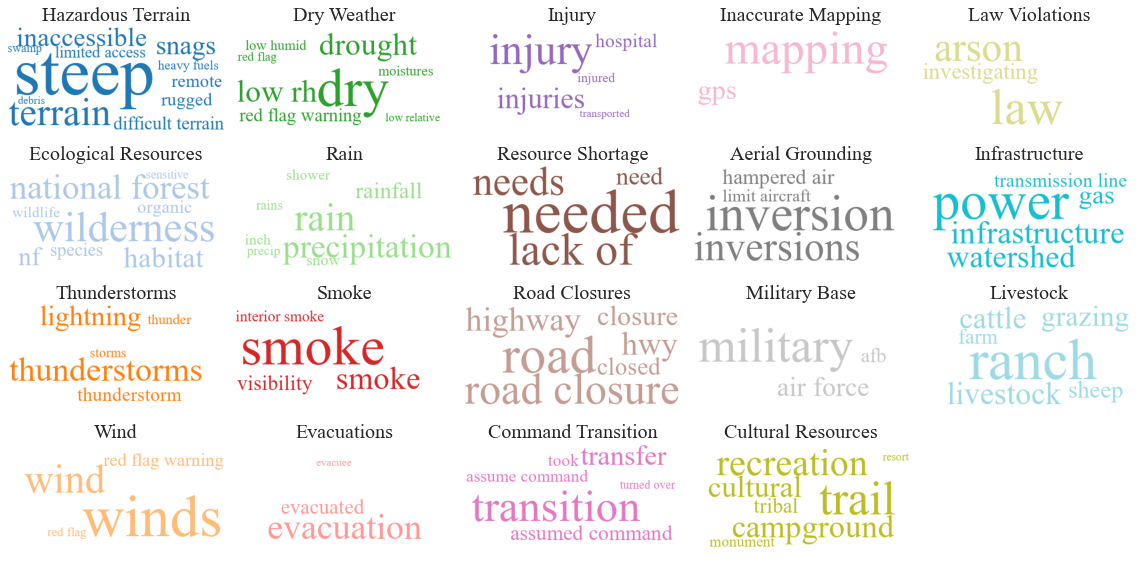

In [20]:
build_word_clouds(word_frequencies, nrows=4, ncols=5, figsize=(16, 8), cmap=None, save=False, save_path=os.path.join('topic_model_results',''), fontsize=20)

## Primary Analysis: 
The primary analysis involves two main outputs:
 - hazard metrics
 - risk matrix

### Hazard Metrics
Hazard metrics, including frequency, rate, and severity, are displayed in a table. 

First, we reorder the dictionary containing fires for each hazard according to the sorted hazard list:

In [21]:
fires = {hazard: fires[hazard] for hazard in hazards_sorted}

Next, we calculate severity and sort it according to the sorted hazard list:

In [22]:
severity_total, severity_table = calc_severity(fires, incident_summary_df ,rm_all_outliers=False, rm_severity_outliers=False)

In [23]:
severity_table = severity_table.set_index('Hazard').reindex(hazards_sorted).reset_index()

For comparison, we also calcluated severity values accross the entire dataset. This allows us to compare the average severity for incidents with certain hazards to a baseline value.

In [24]:
severity_accross_all_incidents = []; injuries_all = []; fatalities_all = []; str_dam_all = []; str_des_all = []
for i in range(len(incident_summary_df)):
    severity = int(incident_summary_df.iloc[i]["STR_DESTROYED_TOTAL"]) + int(incident_summary_df.iloc[i]["STR_DAMAGED_TOTAL"])+ int(incident_summary_df.iloc[i]["INJURIES_TOTAL"])+ int(incident_summary_df.iloc[i]["FATALITIES"])
    severity_accross_all_incidents.append(severity)
    injuries_all.append(int(incident_summary_df.iloc[i]["INJURIES_TOTAL"])); fatalities_all.append(int(incident_summary_df.iloc[i]["FATALITIES"]))
    str_dam_all.append(int(incident_summary_df.iloc[i]["STR_DAMAGED_TOTAL"])); str_des_all.append(int(incident_summary_df.iloc[i]["STR_DESTROYED_TOTAL"]))

Now we save the total dataset information as a single-row dataframe so we can add it to the existing hazard metric table.

In [25]:
total_incidents_df = pd.DataFrame({"Hazard Category": ['Total Reports'],
                                  "Hazard Name": [''],
                                  "OTTO %":[''],
                                   "Total Fire Frequency":[str(len(incident_summary_df))],
                                  "Rate":[str(round(np.average(incident_summary_df['START_YEAR'].value_counts().values),1))+"+-"+str(round(np.std(incident_summary_df['START_YEAR'].value_counts().values),1))],#len(incident_summary_df)/len(years))],
                                  "Fatalities":[str(round(np.average(fatalities_all),1))+"+-"+str(round(np.std(fatalities_all),1))],
                                  "Injuries":[str(round(np.average(injuries_all),1))+"+-"+str(round(np.std(injuries_all),1))],
                                  "Structures Damaged":[str(round(np.average(str_dam_all),1))+"+-"+str(round(np.std(str_dam_all),1))],
                                  "Structures Destroyed":[str(round(np.average(str_des_all),1))+"+-"+str(round(np.std(str_des_all),1))],
                                  "Severity":[str(round(np.average(severity_accross_all_incidents),1))+"+-"+str(round(np.std(severity_accross_all_incidents),1))]},
                                 index =['Total Reports'])

Here we rename the columns for readability: 

In [26]:
values = ['Fatalities', 'Injuries', 'Structures Damaged', 'Structures Destroyed']
for value in values:
    table[value] = severity_table['Average '+value].astype(str) + "+-" + severity_table['std dev '+value].astype(str)

Now we combine the dataframes to get the final primary results table:

In [27]:
table['Severity'] = severity_table['formatted']
columns = ['Hazard Category', 'Hazard Name', 'OTTO %', 'Total Fire Frequency', 'Rate'] + values +['Severity']
table = table[columns]
table = table.set_index('Hazard Category')#.drop(['Hazard Category'], axis=1)
table = table.append(total_incidents_df.drop(['Hazard Category'], axis=1))
display(table)

,Hazard Name,OTTO %,Total Fire Frequency,Rate,Fatalities,Injuries,Structures Damaged,Structures Destroyed,Severity
Environment,Hazardous Terrain,53.3+-36.5,2900,322.2+-120.9,0.0+-0.5,1.4+-3.9,0.8+-10.1,4.5+-41.1,6.8+-46.4
Environment,Ecological Resources,46.8+-35.1,792,88.0+-29.2,0.0+-0.4,2.5+-5.7,1.5+-18.4,6.4+-34.3,10.5+-50.0
Environment,Thunderstorms,55.1+-35.8,1127,125.2+-51.2,0.0+-0.5,1.8+-4.8,1.1+-15.6,5.0+-33.6,8.0+-45.8
Environment,Wind,51.8+-36.3,2950,327.8+-120.2,0.0+-0.5,1.3+-3.9,1.1+-12.1,6.2+-53.2,8.6+-60.1
Environment,Dry Weather,55.4+-36.3,2171,241.2+-92.6,0.0+-0.5,1.5+-4.2,1.4+-13.8,7.6+-61.6,10.6+-69.5
Environment,Rain,64.4+-37.7,1696,188.4+-42.7,0.0+-0.5,1.2+-3.4,1.2+-14.3,5.0+-49.5,7.4+-56.5
Environment,Smoke,48.6+-37.5,1281,142.3+-33.4,0.0+-0.5,1.8+-5.0,1.4+-15.3,7.6+-58.9,10.8+-69.1
Mission,Evacuations,36.0+-31.0,1296,144.0+-58.4,0.1+-0.7,2.5+-5.5,2.5+-18.0,14.6+-80.1,19.6+-90.0
Mission,Injury,56.0+-34.3,783,87.0+-31.7,0.1+-0.5,3.9+-6.2,1.9+-18.5,14.1+-95.0,20.0+-104.9
Mission,Resource Shortage,40.2+-33.7,1229,136.6+-58.3,0.0+-0.6,2.4+-5.4,1.5+-15.5,8.4+-60.0,12.4+-70.8


We can also create a table with just the severity metrics:

In [29]:
avg_injuries = round(np.average(injuries_all))
avg_fatalities = round(np.average(fatalities_all))
avg_des = round(np.average(str_des_all))
avg_dam = round(np.average(str_dam_all))
avg_df = pd.DataFrame({"Total Avg Injuries":[avg_injuries for hazard in hazards],
                     "Total Avg Fatalities":[avg_fatalities for hazard in hazards],
                     "Total Avg Str Dam":[avg_dam for hazard in hazards],
                     "Total Avg Str Des":[avg_des for hazard in hazards]})
severity_results = pd.DataFrame({""})

In [30]:
ICS_results = pd.concat([table.drop(['Total Reports']).reset_index(drop=True), severity_table, avg_df], axis=1)
#ICS_results.to_csv(os.path.join(os.path.dirname(os.getcwd()),'results','ICS_hazards.csv'))

### Risk Matrix of Hazards (rate by severity)

The next part of the primary analysis is to create a risk matrix placing hazards in risk categories according to severity and rate. Risk matrices can be created according to either FAA or USFS specifications.

For display purposes, initialize the matplotlib with the following parameters:

In [31]:
matplotlib.style.use("default")
plt.rcParams["font.family"] = "Times New Roman"

In [32]:
#ICS_results = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'results','ICS_hazards.csv'))

Set the index of the results dataframe to the hazards:

In [33]:
ICS_results.index = ICS_results['Hazard Name']

Calculate the severity category from the results:

In [34]:
severities = get_ICS_severity_FAA(ICS_results, hazards)

Calculate the likelihood category from the rates:

In [35]:
rates = {hazard:float(table[table['Hazard Name']==hazard]['Rate'].values[0].split("+-")[0]) for hazard in hazards}
rates_FAA = get_likelihood_ICS_FAA(rates)

Now you can plot a risk matrix:

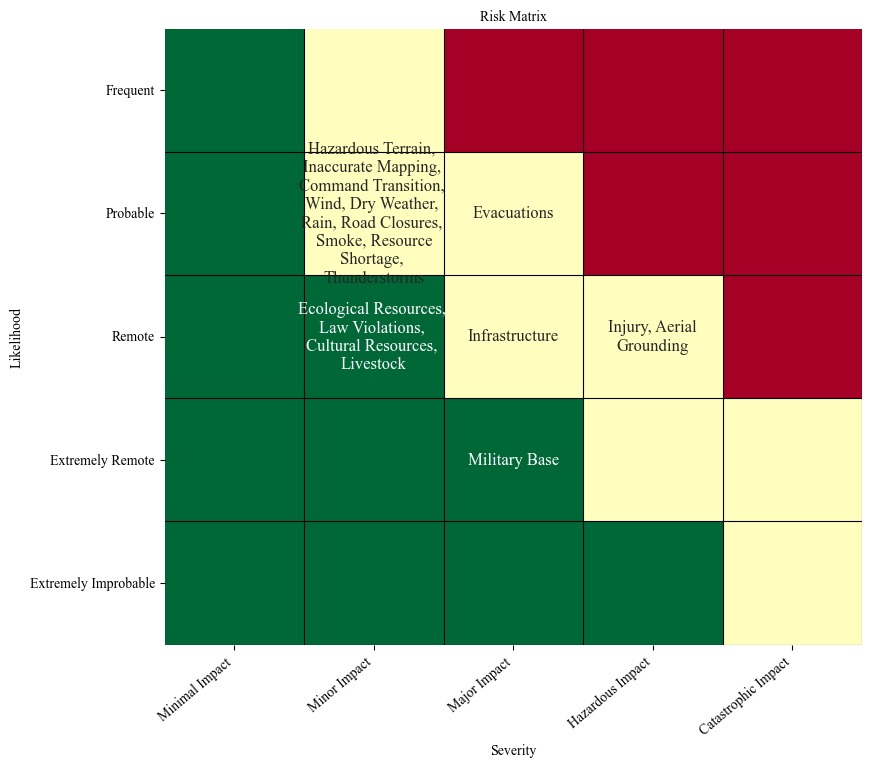

In [36]:
plot_risk_matrix(rates_FAA, severities, figsize=(9,8), results_path=os.path.join('risk_matrix'), save=False, max_chars=22, fontsize=10)

To produces the USFS risk matrix, follow the same method and calculate the likelihood and severity categories:

In [37]:
likelihoods = get_likelihood_ICS_USFS(rates)
severities = get_ICS_severity_USFS(ICS_results, hazards)

In [38]:
severities

{'Evacuations': 'Critical',
 'Hazardous Terrain': 'Marginal',
 'Inaccurate Mapping': 'Marginal',
 'Ecological Resources': 'Marginal',
 'Command Transition': 'Marginal',
 'Wind': 'Marginal',
 'Dry Weather': 'Marginal',
 'Rain': 'Marginal',
 'Law Violations': 'Marginal',
 'Road Closures': 'Marginal',
 'Smoke': 'Marginal',
 'Military Base': 'Critical',
 'Cultural Resources': 'Marginal',
 'Resource Shortage': 'Marginal',
 'Thunderstorms': 'Marginal',
 'Infrastructure': 'Critical',
 'Injury': 'Critical',
 'Livestock': 'Marginal',
 'Aerial Grounding': 'Critical'}

Now plot the risk matrix:

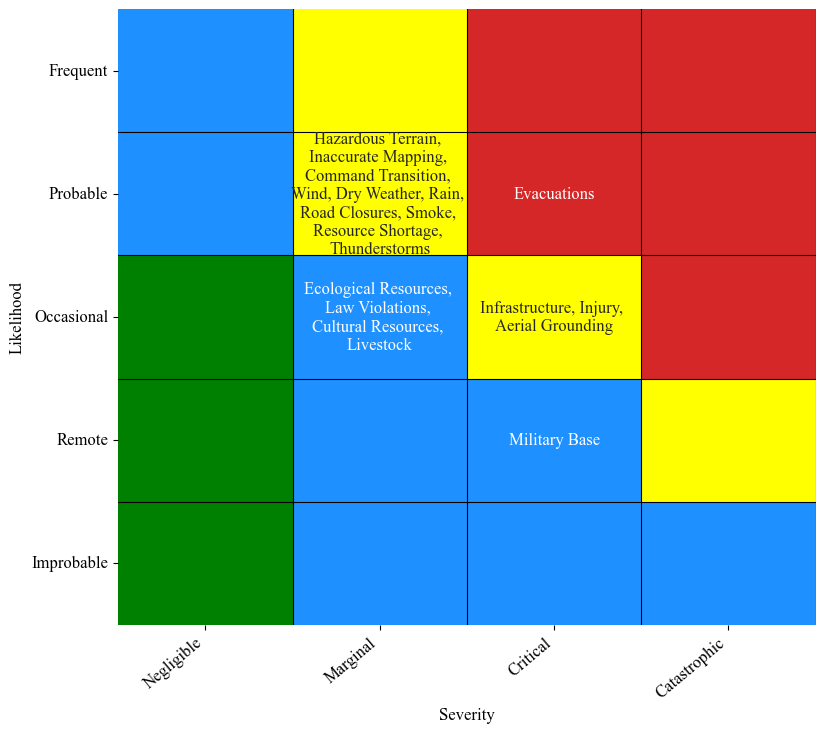

In [39]:
plot_USFS_risk_matrix(likelihoods, severities, figsize=(9,8), results_path=os.path.join('risk_matrix'), save=False, max_chars=24,fontsize=12)#fontsize)

## Graphic Analysis: 
In the graphic analysis, we produce time series graphs of hazard metrics and predictors over time.
- Time Series
    - Hazard Metrics: OTTO, Severity, Frequency 
    - Predictors

### Hazard Metrics Time Series

Here we graph time series for relevant hazard metrics. The metrics of interest in this example are:
 - frequency, 
 - Operational Time To Occurrence (OTTO) in percent containment
 - severity

First we set the graphing parameters for consistency. For the time series we prefer seaborn style. Then, we format the data to be in the same order of the sorted hazards.

In [40]:
matplotlib.style.use("seaborn")
plt.rcParams["font.family"] = "Times New Roman"
categories = table.index[:-1]#['Hazard Category'][:-1].index
metric_data = [time_of_occurence_days, time_of_occurence_pct_contained, frequency, frequency_fires]
time_of_occurence_days = {hazard: time_of_occurence_days[hazard] for hazard in hazards_sorted}
time_of_occurence_pct_contained = {hazard: time_of_occurence_pct_contained[hazard] for hazard in hazards_sorted}
frequency = {hazard: frequency[hazard] for hazard in hazards_sorted}
frequency_fires = {hazard: frequency_fires[hazard] for hazard in hazards_sorted}

In [41]:
categories

Index(['Environment', 'Environment', 'Environment', 'Environment',
       'Environment', 'Environment', 'Environment', 'Mission', 'Mission',
       'Mission', 'Mission', 'Mission', 'Mission', 'Mission',
       'Wildland Urban Interface', 'Wildland Urban Interface',
       'Wildland Urban Interface', 'Wildland Urban Interface',
       'Wildland Urban Interface'],
      dtype='object')

Now we can input the metrics into the graph_ICS_time_series utility function, which uses graphing methods from the trend analysis module. This results in four graphs, one for the OTTO in days, OTTO in perect containment, total frequency (i.e., number of reports with hazards - can have multiple per fire), and the fire frequency (i.e., number of fires with hazards)

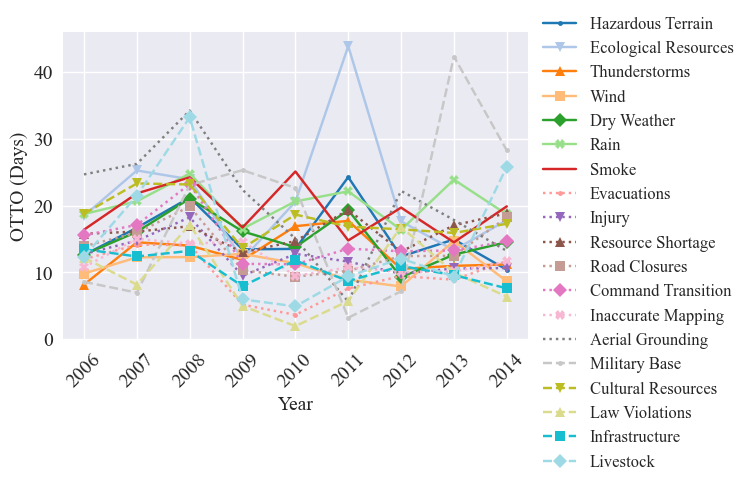

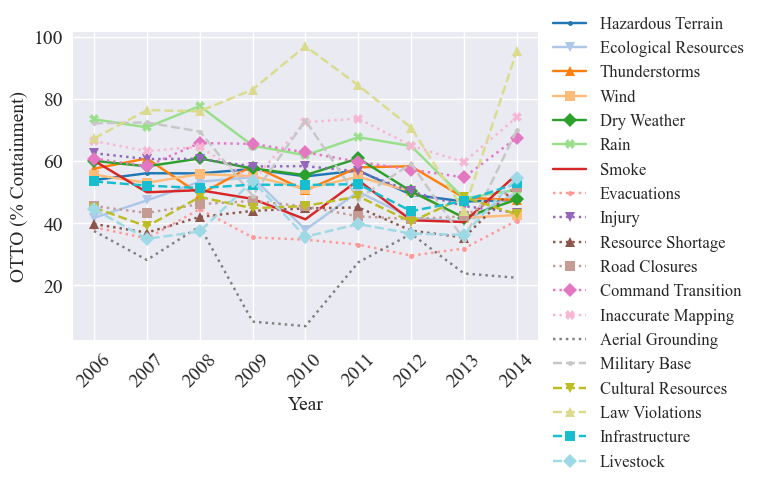

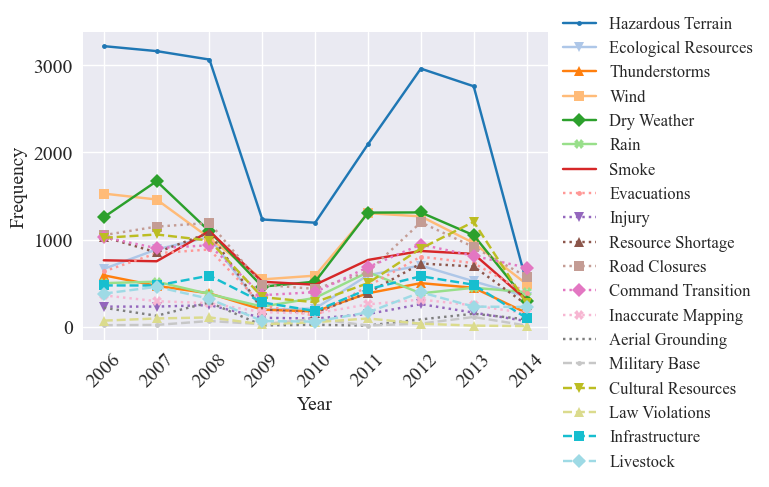

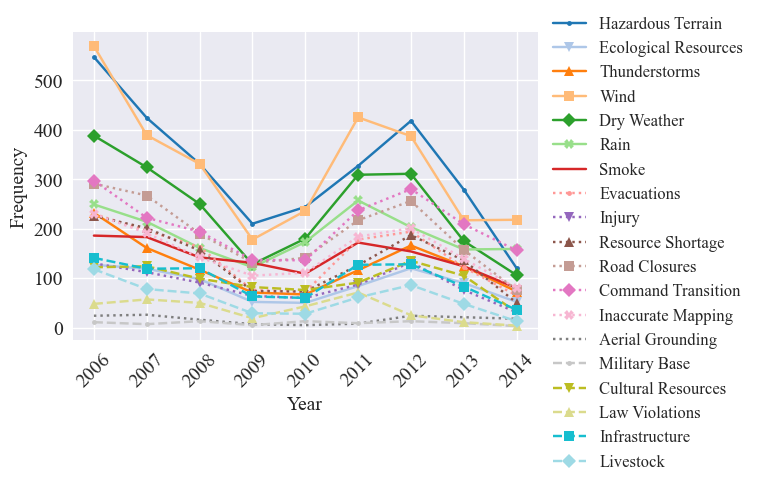

In [42]:
graph_ICS_time_series(time_of_occurence_days, time_of_occurence_pct_contained, frequency, frequency_fires, hazards, categories, save=False, std_dev=False, results_path=os.getcwd(), figsize=figsize, fontsize=fontsize, titles=False)

To prepare for the secondary analysis, we minmix scale the frequency:

In [43]:
frequencies_fire = {hazard: [frequency_fires[hazard][year] for year in frequency_fires[hazard]] for hazard in frequency_fires}
fire_freqs_scaled = {hazard: minmax_scale(frequencies_fire[hazard]) for hazard in frequencies_fire}

### Predictor Time Series
We are also interested in how potential predictors vary accross time. The predictors of interest here are:
- fire characteristics
- operations
- intensity

Each of the predictors above are calculated by combining multiple lower level predictors. 
Hence, we first define the combine_predictors function and graph each of the subpredictors.

In [44]:
def combine_predictors(predictors=[], scale=True):
    max_weight = 1/len(predictors)
    num_values = len(predictors[-1])
    if scale: 
        variable_weights = [minmax_scale(p) for p in predictors]
    else:
        variable_weights = predictors
    combined_vars = [[max_weight*var_weight for var_weight in var_weight_list] for var_weight_list in variable_weights]
    combined_vars = [sum([combined_vars[var][i] for var in range(len(combined_vars))]) for i in range(num_values)]
    return combined_vars

In [45]:
combined_predictors = pd.DataFrame()

#### Fire Characteristics
We start with the fire characteristics combined predictor. It is formed from the fire frequency, acres burned, and the number of days a fire burns on average per year. Potentially add FSR (WF_MAX_FSR), number of complexes (COMPLEX), evacuations (EVACUATION_REPORTED).

We define the columns of interest, then filter the incident summary reports by these columns:


In [46]:
fire_trends_cols = ["FINAL_ACRES", "FOD_DISCOVERY_DOY", "FOD_CONTAIN_DOY", "START_YEAR"]
fire_trends_df = incident_summary_df[fire_trends_cols]

We get the fire frequency per year by counting the number of reports per year:

In [47]:
counts = fire_trends_df["START_YEAR"].value_counts()
count = {int(year):counts[year] for year in counts.index.sort_values()}

In [48]:
years = count.keys()

Next we calculate the total and average days burning and acreage per year:

In [49]:
average_days_burning = {}
total_days_burning = {}
total_acres = {}
average_acres = {}
for year in years:
    temp_df = fire_trends_df.loc[fire_trends_df['START_YEAR']==year]
    list_of_days_burning = [temp_df.iloc[i]["FOD_CONTAIN_DOY"]-temp_df.iloc[i]['FOD_DISCOVERY_DOY'] for i in range(len(temp_df.dropna(subset=['FOD_DISCOVERY_DOY', "FOD_CONTAIN_DOY"]).reset_index(drop=True)))]
    average_days_burning[year] = np.average(list_of_days_burning)
    total_days_burning[year] = np.sum(list_of_days_burning)
    list_of_acres = temp_df['FINAL_ACRES'].dropna().tolist()
    average_acres[year] = np.average(list_of_acres)
    total_acres[year] = np.sum(list_of_acres)
#print(total_days_burning)

Now we can calculate the combined predictor variable, fire characteristics, using the function defined above.

In [50]:
fire_predictors = [total_acres.values(), counts, total_days_burning.values()]

In [51]:
fire_predictors = [total_acres.values(), counts, total_days_burning.values()]
combined_predictors['Fire Characteristics'] = combine_predictors(fire_predictors)
combined_predictors.index = years

##### Graphs
We graph the average and total values for the subpredictors comprising fire characteristics.

First we scale the predictors using minmax scaling:

In [52]:
av_acres = average_acres.values()
av_days_burn = average_days_burning.values()
count = count.values()
freq_scaled = minmax_scale(count)
av_days_burn_scaled = minmax_scale(av_days_burn)
av_acres_scaled = minmax_scale(av_acres)

total_days_burn = total_days_burning.values()
total_acre = total_acres.values()
total_days_burn_scaled = minmax_scale(total_days_burn)
total_acres_scaled = minmax_scale(total_acre)

Now we graph the predictors:

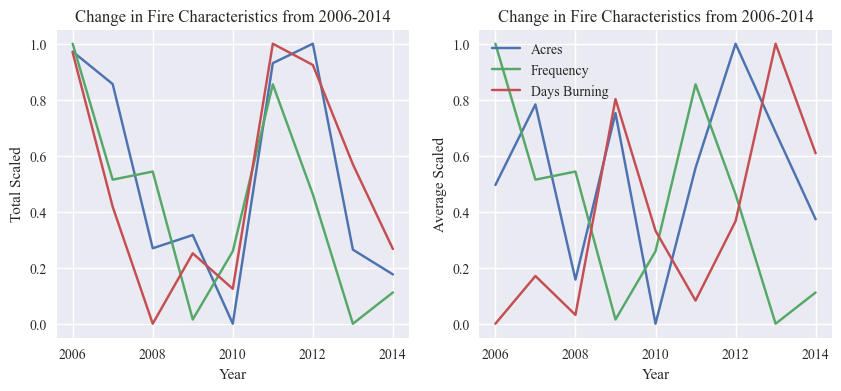

In [53]:
nrows = 1
ncols = 2
fig, axs = plt.subplots(nrows = nrows,
                            ncols = ncols,
                            figsize = (10,4))
fire_labels = ['Acres', 'Frequency', 'Days Burning']
fire_totals = [total_acres_scaled, freq_scaled, total_days_burn_scaled]
fire_avgs = [av_acres_scaled, freq_scaled, av_days_burn_scaled]
fig, axs[0] = plot_predictors(fire_totals, fire_labels, time=years, time_label='Year', title="Change in Fire Characteristics from 2006-2014", 
                totals=True, averages=False, scaled=True, figsize=(12, 5), axs=axs[0], fig=fig, show=False, legend=False)
fig, axs[1] = plot_predictors(fire_avgs, fire_labels, time=years, time_label='Year', title="Change in Fire Characteristics from 2006-2014", 
                totals=False, averages=True, scaled=True, figsize=(12, 5), axs=axs[1], fig=fig, show=False)
plt.show()

#### Operations
Next we examine the operational trends predictor, which is defined by aerial assets (total and max in one day), personnel (total and max in one day), and projected cost.
Could also potentially add number of sit reports (INC_MGMT_NUM_SITREPS)??

First we identify the columns of interest and filter the incident summary dataframe.

In [54]:
operational_trends_cols = ["TOTAL_AERIAL_SUM", "TOTAL_PERSONNEL_SUM", "WF_PEAK_AERIAL", "WF_PEAK_PERSONNEL", "START_YEAR","PROJECTED_FINAL_IM_COST"]
operational_trends_df = incident_summary_df[operational_trends_cols]

Next we calculate the average and total values for the sub predictors:

In [55]:
total_aerial = {}
average_aerial = {}
total_person = {}
average_person = {}
total_cost = {}
average_cost = {}
for year in years:
    list_of_person = []
    list_of_aerial = []
    temp_df = operational_trends_df.loc[operational_trends_df['START_YEAR']==year]
    list_of_person = temp_df['WF_PEAK_PERSONNEL'].fillna(value=0).tolist()
    list_of_aerial = temp_df["WF_PEAK_AERIAL"].fillna(value=0).tolist()
    list_of_cost = temp_df["PROJECTED_FINAL_IM_COST"].dropna().tolist()
    average_aerial[year] = np.average(list_of_aerial)
    total_aerial[year] = np.sum(list_of_aerial)
    average_person[year] = np.average(list_of_person)
    total_person[year] = np.sum(list_of_person)
    average_cost[year] = np.average(list_of_cost)
    total_cost[year] = np.sum(list_of_cost)

Now we calculate the combined operations predictor variable:

In [56]:
ops_predictors = [total_cost.values(), total_aerial.values(), total_person.values()]
combined_predictors['Operations'] = combine_predictors(ops_predictors)

Now we grab the values and minmax scale them for graphing:

In [57]:
av_aerial = average_aerial.values()
total_aerial = total_aerial.values()

av_person = average_person.values()
total_person = total_person.values()
av_cost = average_cost.values()
total_cost = total_cost.values()

In [58]:
av_cost_scaled = minmax_scale(av_cost)
av_person_scaled = minmax_scale(av_person)
av_aerial_scaled = minmax_scale(av_aerial)

total_cost_scaled = minmax_scale(total_cost)
total_person_scaled = minmax_scale(total_person)
total_aerial_scaled = minmax_scale(total_aerial)

##### Graphs

We then graph each of the subpredictors together, both the averages and total values.

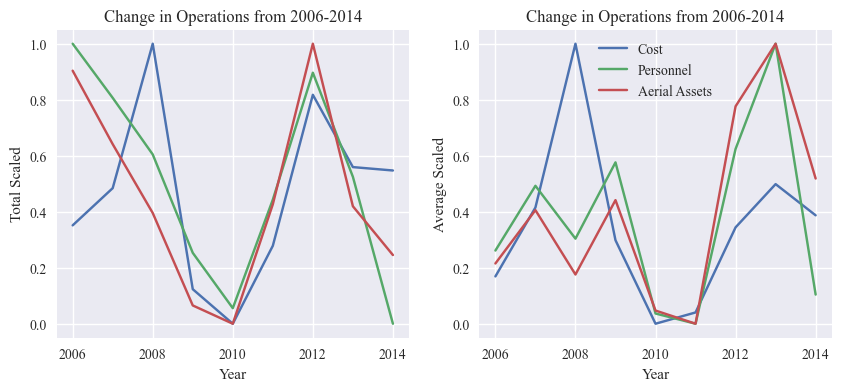

In [59]:
nrows = 1
ncols = 2
fig, axs = plt.subplots(nrows = nrows,
                            ncols = ncols,
                            figsize = (10,4))
operations_labels = ['Cost', 'Personnel', 'Aerial Assets']
operations_totals = [total_cost_scaled, total_person_scaled, total_aerial_scaled]
operations_avgs = [av_cost_scaled, av_person_scaled, av_aerial_scaled]
fig, axs[0] = plot_predictors(operations_totals, operations_labels, time=years, time_label='Year', title="Change in Operations from 2006-2014", 
                totals=True, averages=False, scaled=True, figsize=(12, 5), axs=axs[0], fig=fig, show=False, legend=False)
fig, axs[1] = plot_predictors(operations_avgs, operations_labels, time=years, time_label='Year', title="Change in Operations from 2006-2014", 
                totals=False, averages=True, scaled=True, figsize=(12, 5), axs=axs[1], fig=fig, show=False)
plt.show()

#### Intensity
The final predictor we consider is the intensity predictor, which is defined by the number of injuries, number of fatalities, number of structures damaged, number of structures destroyed.

Again, first we identify the relevant columns and filter the incident dataframe to include them:

In [60]:
intensity_cols = ["STR_DESTROYED_TOTAL","STR_DAMAGED_TOTAL","INJURIES_TOTAL","FATALITIES", "START_YEAR"]
intensity_df = incident_summary_df[intensity_cols]

Now we caluclate the total and average values for each of the subpredictors:

In [61]:
total_str_des = {}
average_str_des = {}
total_str_damage = {}
average_str_damage = {}
total_injuries = {}
average_injuries = {}
total_fatalities = {}
average_fatalities = {}

for year in years:
    temp_df =intensity_df.loc[intensity_df['START_YEAR']==year]
    list_of_dest = temp_df["STR_DESTROYED_TOTAL"].tolist()
    list_of_dam = temp_df["STR_DAMAGED_TOTAL"].tolist()
    list_of_injury = temp_df["INJURIES_TOTAL"].tolist()
    list_of_fatalities = temp_df["FATALITIES"].tolist()
    total_str_des[year] = np.sum(list_of_dest)
    average_str_des[year] = np.average(list_of_dest)
    total_str_damage[year] = np.sum(list_of_dam)
    average_str_damage[year] = np.average(list_of_dam)
    total_injuries[year] = np.sum(list_of_injury)
    average_injuries[year] = np.average(list_of_injury)
    total_fatalities[year] = np.sum(list_of_fatalities)
    average_fatalities[year] = np.average(list_of_fatalities)

The combined intensity predictor is then calculated:

In [62]:
intensity_predictors = [total_fatalities.values(), total_str_damage.values(), total_injuries.values(), total_str_des.values()]
combined_predictors['Intensity'] = combine_predictors(intensity_predictors)

Once again, we grab the values and minmax scale them for graphing:

In [63]:
av_des = average_str_des.values()
total_des = total_str_des.values()
av_damage = average_str_damage.values()
total_damage = total_str_damage.values()
av_injury = average_injuries.values()
total_injury = total_injuries.values()
av_fatality = average_fatalities.values()
total_fatality = total_fatalities.values()

In [64]:
total_fatality_scaled = minmax_scale(total_fatality)
total_injury_scaled = minmax_scale(total_injury)
total_damage_scaled = minmax_scale(total_damage)
total_des_scaled = minmax_scale(total_des)

av_fatality_scaled = minmax_scale(av_fatality)
av_injury_scaled = minmax_scale(av_injury)
av_damage_scaled = minmax_scale(av_damage)
av_des_scaled = minmax_scale(av_des)

##### Graphs
The subpredictors of intensity are graphed together as a time series:

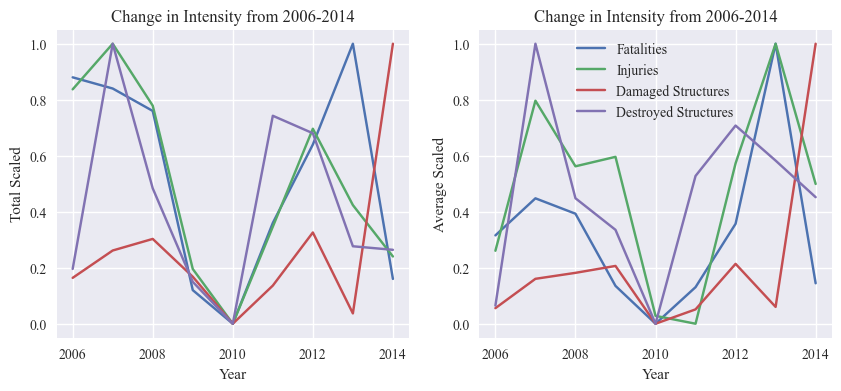

In [65]:
nrows = 1
ncols = 2
fig, axs = plt.subplots(nrows = nrows,
                            ncols = ncols,
                            figsize = (10,4))
intensity_labels = ['Fatalities', 'Injuries', 'Damaged Structures', 'Destroyed Structures']
intensity_totals = [total_fatality_scaled, total_injury_scaled, total_damage_scaled, total_des_scaled]
intensity_avgs = [av_fatality_scaled, av_injury_scaled, av_damage_scaled, av_des_scaled]
fig, axs[0] = plot_predictors(intensity_totals, intensity_labels, time=years, time_label='Year', title="Change in Intensity from 2006-2014", 
                totals=True, averages=False, scaled=True, figsize=(12, 5), axs=axs[0], fig=fig, show=False, legend=False)
fig, axs[1] = plot_predictors(intensity_avgs, intensity_labels, time=years, time_label='Year', title="Change in Intensity from 2006-2014", 
                totals=False, averages=True, scaled=True, figsize=(12, 5), axs=axs[1], fig=fig, show=False)
plt.show()

#### Combined predictors time series
To see how the predictors compare together, we graph all three of the combined predictors and their subpredictors in one graph. We graph both the total and average values.

First we define dictionaries to contain the data and minmax scale the total data values:

In [66]:
totals = {"Fire Frequency": count,
    "total Days Fires Burned": total_days_burn,
    "total Acres Fires Burned": total_acre,
    "total Aerial Assets": total_aerial,
    "total Personnel": total_person,
    "total Cost": total_cost,
    "total Structures Damaged": total_damage,
    "total Structures Destroyed": total_des,
    "total Injuries": total_injury,
    "total Fatalities": total_fatality}
totals_df = pd.DataFrame(totals)

averages = {
    "fire frequency": count,
    "average days fire burns": av_days_burn,
    "average acres fire burns": av_acres,
    "average aerial assets per fire": av_aerial,
    "average personnel per fire": av_person,
    "average cost per fire": av_cost,
    "average structures damaged per fire": av_damage,
    "average structures destroyed per fire": av_des,
    "average injuries per fire": av_injury,
    "average fatalities per fire": av_fatality}
avs_df = pd.DataFrame(averages)

totals_scaled = {feature:minmax_scale(totals[feature]) for feature in totals}


Next we scale to combined predictors as well:

In [67]:
combined_predictors_scaled = combined_predictors.copy()
for col in combined_predictors_scaled:
    combined_predictors_scaled[col] = minmax_scale(combined_predictors_scaled[col])

Now we define the line style, markers, and colors for the predictor graphs:

In [68]:
lines = {"Fire Frequency": '--',
    "total Days Fires Burned": '--',
    "total Acres Fires Burned": '--',
    "total Aerial Assets": '-',
    "total Personnel": '-',
    "total Cost": '-',
    "total Structures Damaged": ':',
    "total Structures Destroyed": ':',
    "total Injuries": ':',
    "total Fatalities": ':'}
colors = cm.tab10(np.linspace(0, 1, len(lines)))
colors_dict = {}
i = 0
for feature in lines:
    colors_dict[feature] = colors[i]
    i+=1
markers = {"Fire Frequency": '.',
    "total Days Fires Burned": 'v',
    "total Acres Fires Burned": '^',
    "total Aerial Assets": 's',
    "total Personnel": 'p',
    "total Cost": 'P',
    "total Structures Damaged": 'h',
    "total Structures Destroyed": 'X',
    "total Injuries": 'D',
    "total Fatalities": '*'}

Here we plot the total scaled value for each predictor:

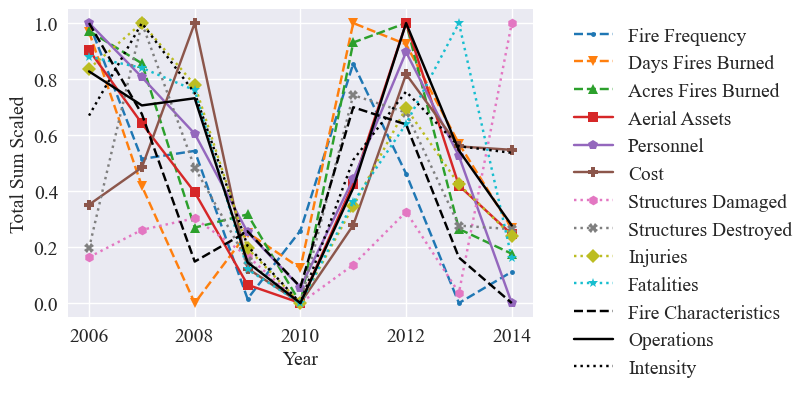

In [69]:
plt.figure(figsize=figsize)
plt.ylabel("Total Sum Scaled", fontsize=fontsize)
plt.xlabel("Year", fontsize=fontsize)
for feature in totals_scaled:
    plt.plot(years, totals_scaled[feature], label=feature.replace("total ",""), linestyle=lines[feature], marker=markers[feature], color=colors_dict[feature])
    plt.tick_params(labelsize=fontsize)
plt.plot(years,combined_predictors_scaled['Fire Characteristics'], label='Fire Characteristics', color='black', linestyle='--')
plt.plot(years,combined_predictors_scaled['Operations'], label = 'Operations', color='black', linestyle = '-')
plt.plot(years,combined_predictors_scaled['Intensity'], label = 'Intensity', color = 'black', linestyle = ':')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=fontsize)
#plt.savefig('predictors_scaled.pdf', bbox_inches="tight") 
plt.show()

Next we graph the unscaled values:

In [70]:
combined_predictors_unscaled = pd.DataFrame()
fire_predictors = [total_acres.values(), counts, total_days_burning.values()]
combined_predictors_unscaled['Fire Characteristics'] = combine_predictors(fire_predictors, scale=False)
combined_predictors_unscaled.index = years
intensity_predictors = [total_fatalities.values(), total_str_damage.values(), total_injuries.values(), total_str_des.values()]
ops_predictors = [total_cost, total_aerial, total_person]
combined_predictors_unscaled['Operations'] = combine_predictors(ops_predictors, scale=False)
combined_predictors_unscaled['Intensity'] = combine_predictors(intensity_predictors, scale=False)

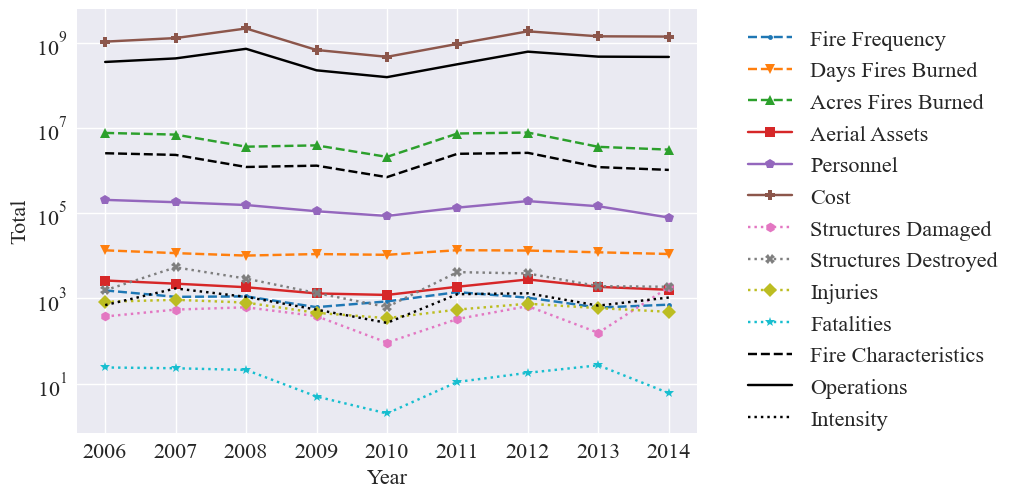

In [71]:
plt.figure()
plt.ylabel("Total", fontsize=16)
plt.xlabel("Year", fontsize=16)
for feature in totals:
    plt.plot(years, totals[feature], label=feature.replace("total ",""), linestyle=lines[feature], marker=markers[feature], color=colors_dict[feature])
    plt.tick_params(labelsize=16)
plt.plot(years,combined_predictors_unscaled['Fire Characteristics'], label='Fire Characteristics', color='black', linestyle='--')
plt.plot(years,combined_predictors_unscaled['Operations'], label = 'Operations', color='black', linestyle = '-')
plt.plot(years,combined_predictors_unscaled['Intensity'], label = 'Intensity', color = 'black', linestyle = ':')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)
plt.yscale('log')
#plt.savefig('predictors.pdf', bbox_inches="tight") 
plt.show()

## Secondary Analysis:
The secondary analysis includes inferential statistics methods, specifically:
- Correlation matrix
- Multiple Regression

### Combined Predictors

We use the combined predictors, rather than the raw predictors, for the secondary analysis. 

### Correlation Matrix
A correlation matrix is produced to examine the pairwise relationship between hazard frequency and each predictor. 

This is done using the create_correlation_matrix function in the trend analysis module. The scaled predictors and hazard frequencies are passed into the function arguments:

In [72]:
corrMatrix_fires, correlation_mat_total_fires, p_values = create_correlation_matrix(combined_predictors_scaled, fire_freqs_scaled, graph=False, figsize=(9,8), fontsize=12)

For display purposes, the correlation matrix can be reshaped to show hazards on one axis and predictors on the other:

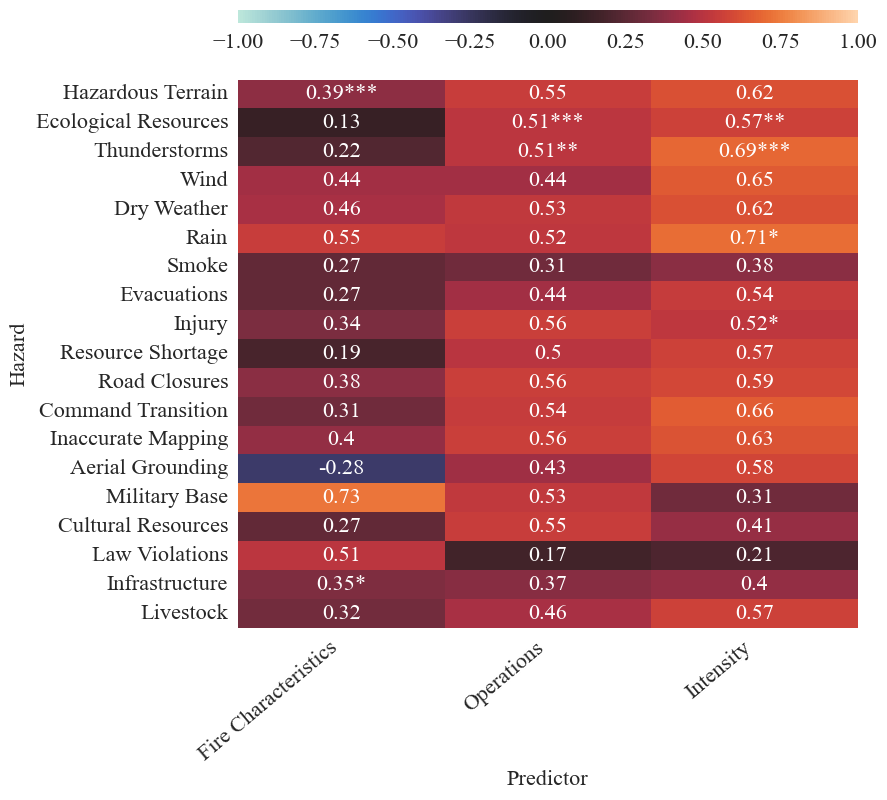

In [73]:
predictors = [p for p in combined_predictors_scaled]
hazards = [h for h in fire_freqs_scaled]
reshape_correlation_matrix(corrMatrix_fires, p_values, predictors, hazards)

The full correlation matrix has correlations between all hazard and predictor pairs:

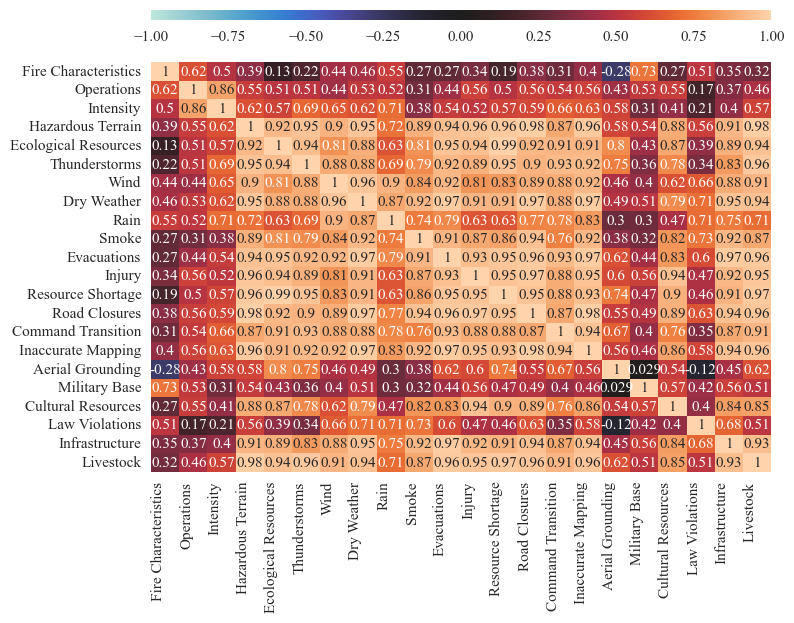

In [74]:
corrMatrix_fires, correlation_mat_total_fires, p_values = create_correlation_matrix(combined_predictors_scaled, fire_freqs_scaled, graph=True, figsize=(8,6), fontsize=11, save=False, results_path=os.path.join('correlation_matrix'))

### Multiple regression
Typically multiple regression is used as a prediction algorithm where given a certain set of continuous inputs X=(x1,2,...xn), the regression predicts the value of continuous variable, y. Multiple regression uses a linear combination of X to produce y, and the error in y/goodness of fit indicates how good the model and predictors are at predicting the target.

The importance of a predictor, xi, is evaluated by shuffling its input values, and seeing how the goodness of fit/error changes.

**Our goal:** 

use regression to determine what the most important predictors are for the frequency of hazards. Since we have a limited number of data points (9) we will not be predicting on unseen data.

**Inputs/Predictors**: 

All operations trends, fire characteristics, and intensity

**Output/y:**

annual frequency of hazards time series

**Method:**

for each hazard, use its frequency time series:
1. fit linear regression model to the X,y
2. calculate correlation coefficient
For each Xi:
3. record the regression coefficient (beta)

Future goal: use ML to determine whether or not a hazard will occur based on past incident reports

The output of the regression analysis is two graphs and a dataframe. The first graph shows the correlation coeffiecient (R2) for the full model with all three predictors for each hazard. The second graph show the importance of each predictor for each hazard. The results dataframes store the numeric information from the graphs. 

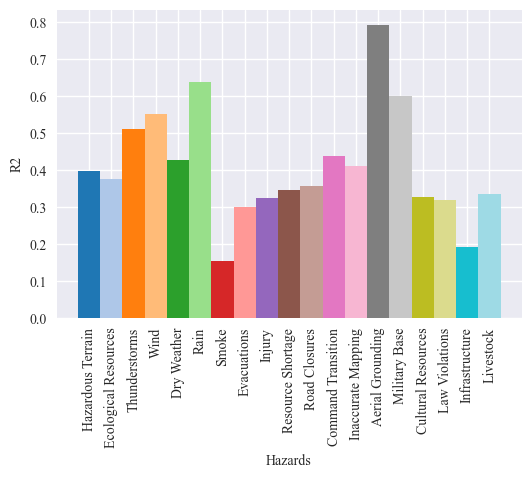

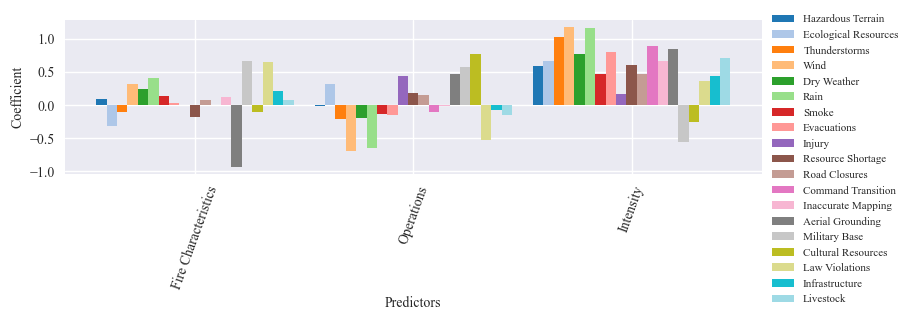

,hazard,R2 for full model,MSE for full model,Fire Characteristics removed score,Operations removed score,Intensity removed score,Fire Characteristics removed MSE,Operations removed MSE,Intensity removed MSE
0,Hazardous Terrain,0.398,0.048,0.409,0.406,-0.237,0.047,0.048,0.099
1,Ecological Resources,0.377,0.089,0.039,0.123,-0.113,0.138,0.126,0.160
2,Thunderstorms,0.511,0.047,0.450,0.471,-1.205,0.053,0.051,0.212
3,Wind,0.552,0.042,0.351,-0.748,-1.659,0.061,0.165,0.251
4,Dry Weather,0.426,0.062,0.367,0.361,-0.381,0.068,0.069,0.149
5,Rain,0.639,0.036,0.145,-0.455,-1.419,0.086,0.146,0.242
6,Smoke,0.154,0.084,0.129,0.161,-0.146,0.086,0.083,0.114
7,Evacuations,0.301,0.087,0.311,0.287,-0.505,0.086,0.089,0.188
8,Injury,0.323,0.067,0.320,-0.393,0.276,0.067,0.137,0.071
9,Resource Shortage,0.347,0.072,0.173,0.212,-0.158,0.091,0.087,0.127


,hazard,R2 for full model,MSE for full model,Fire Characteristics removed score,Operations removed score,Intensity removed score,Fire Characteristics removed MSE,Operations removed MSE,Intensity removed MSE
0,Hazardous Terrain,0.398,0.048,0.010,0.008,0.636,0.001,0.001,-0.051
1,Ecological Resources,0.377,0.089,0.338,0.254,0.490,-0.049,-0.037,-0.070
2,Thunderstorms,0.511,0.047,0.061,0.040,1.716,-0.006,-0.004,-0.165
3,Wind,0.552,0.042,0.201,1.301,2.211,-0.019,-0.123,-0.209
4,Dry Weather,0.426,0.062,0.059,0.065,0.807,-0.006,-0.007,-0.087
5,Rain,0.639,0.036,0.495,1.094,2.059,-0.050,-0.110,-0.206
6,Smoke,0.154,0.084,0.025,0.007,0.300,-0.002,0.001,-0.030
7,Evacuations,0.301,0.087,0.010,0.013,0.805,0.001,-0.002,-0.101
8,Injury,0.323,0.067,0.003,0.716,0.048,-0.000,-0.070,-0.005
9,Resource Shortage,0.347,0.072,0.174,0.134,0.505,-0.019,-0.015,-0.055


,Hazardous Terrain,Ecological Resources,Thunderstorms,Wind,Dry Weather,Rain,Smoke,Evacuations,Injury,Resource Shortage,Road Closures,Command Transition,Inaccurate Mapping,Aerial Grounding,Military Base,Cultural Resources,Law Violations,Infrastructure,Livestock
Fire Characteristics,0.095744,-0.313514,-0.105875,0.318352,0.241583,0.410931,0.132562,0.030633,-0.008230,-0.175735,0.067870,-0.005561,0.114858,-0.931697,0.657452,-0.113661,0.645235,0.216450,0.075068
Operations,-0.022295,0.309108,-0.211922,-0.694471,-0.200577,-0.642130,-0.136309,-0.146819,0.436775,0.177629,0.154156,-0.102439,-0.013382,0.463498,0.578210,0.774194,-0.530265,-0.083715,-0.151685
Intensity,0.589151,0.659442,1.020362,1.178706,0.771584,1.156592,0.469682,0.801286,0.170047,0.603995,0.464643,0.895520,0.654770,0.843958,-0.560887,-0.258116,0.361587,0.431959,0.701494


In [75]:
predictors = [p for p in combined_predictors_scaled]
hazards = [h.replace("total ","") for h in fire_freqs_scaled]
results_df, delta_df, coefficient_df = multiple_reg_feature_importance(predictors, hazards, correlation_mat_total_fires, 
                                                       save=False, results_path=os.path.join('multiple_regression'),
                                                      r2_figsize=figsize, r2_fontsize=fontsize-4, predictor_import_figsize = (9, 2), predictor_import_fontsize=fontsize-4)
display(results_df, delta_df, coefficient_df)

### Full predictors

As an experiment, we also perform the secondary analysis with the full set of subpredictors. This is not recommended for robust analysis due to the small sample of years in the hazard dataset. Specifically, there are more predictors than years in the dataset so the regression model will always have a perfect fit.

In [76]:
corrMatrix_fires, correlation_mat_total_fires, p_values = create_correlation_matrix(totals_scaled, fire_freqs_scaled, graph=False)

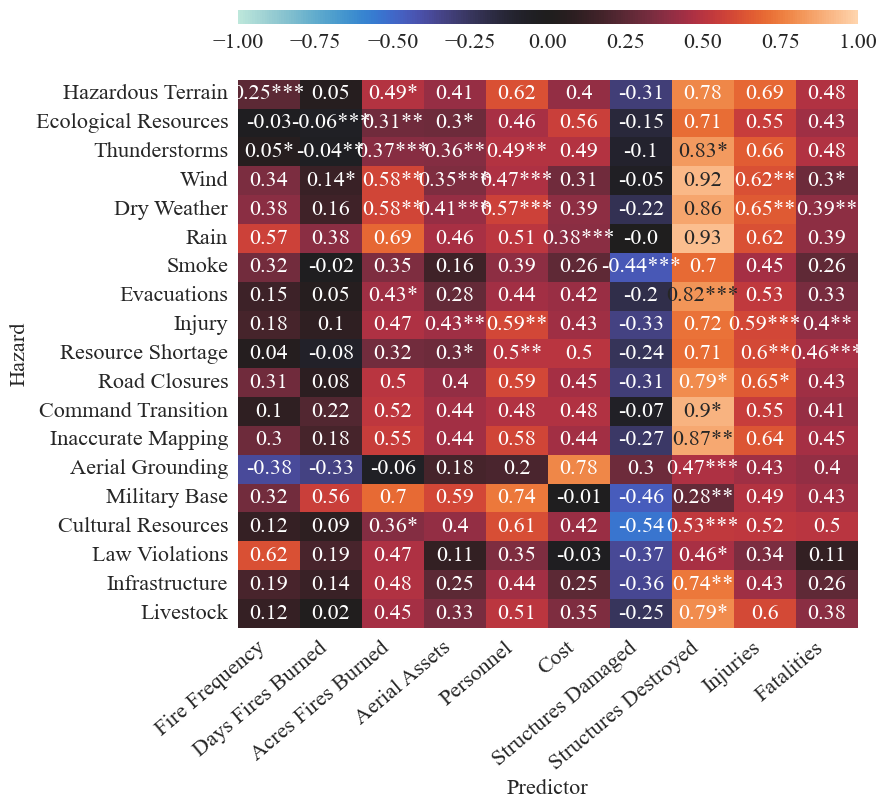

In [77]:
predictors = [p for p in totals_scaled]
hazards = [h for h in fire_freqs_scaled]
reshape_correlation_matrix(corrMatrix_fires, p_values, predictors, hazards)

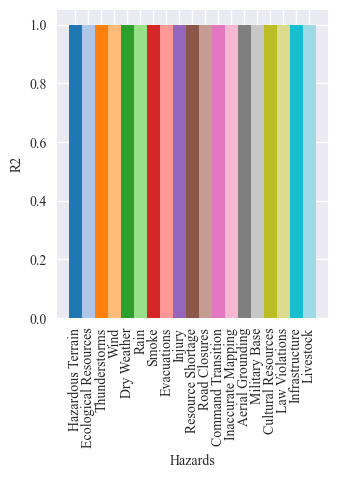

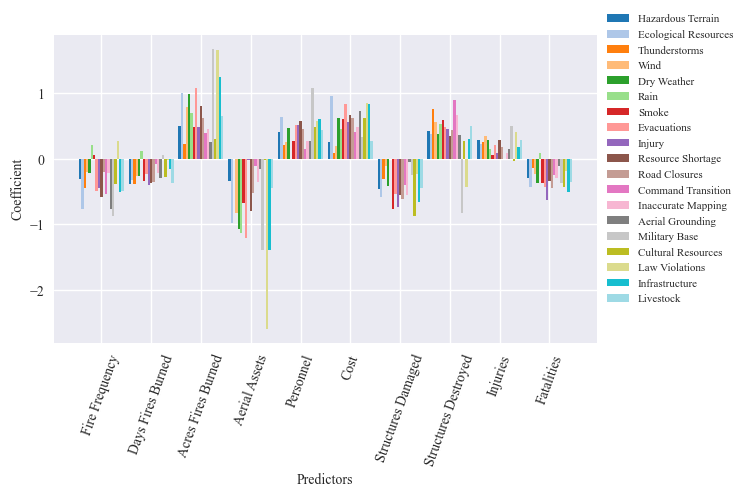

,hazard,R2 for full model,MSE for full model,Fire Frequency removed score,total Days Fires Burned removed score,total Acres Fires Burned removed score,total Aerial Assets removed score,total Personnel removed score,total Cost removed score,total Structures Damaged removed score,...,Fire Frequency removed MSE,total Days Fires Burned removed MSE,total Acres Fires Burned removed MSE,total Aerial Assets removed MSE,total Personnel removed MSE,total Cost removed MSE,total Structures Damaged removed MSE,total Structures Destroyed removed MSE,total Injuries removed MSE,total Fatalities removed MSE
0,Hazardous Terrain,1.0,0.0,0.680,0.206,-0.237,0.553,0.450,0.787,0.523,...,0.026,0.064,0.099,0.036,0.044,0.017,0.038,0.018,0.015,0.022
1,Ecological Resources,1.0,0.0,-0.082,0.696,-1.720,-1.004,0.230,-0.698,0.570,...,0.155,0.044,0.391,0.288,0.110,0.244,0.062,0.014,0.010,0.050
2,Thunderstorms,1.0,0.0,0.450,0.353,0.784,1.000,0.881,0.977,0.810,...,0.053,0.062,0.021,0.000,0.011,0.002,0.018,0.055,0.012,0.005
3,Wind,1.0,0.0,0.894,0.694,-1.538,-1.166,0.810,0.891,0.974,...,0.010,0.029,0.240,0.205,0.018,0.010,0.002,0.031,0.024,0.014
4,Dry Weather,1.0,0.0,0.877,0.736,-2.479,-2.215,0.448,0.040,0.714,...,0.013,0.028,0.375,0.347,0.060,0.103,0.031,0.014,0.016,0.035
5,Rain,1.0,0.0,0.893,0.942,-0.920,-2.795,1.000,0.466,1.000,...,0.011,0.006,0.192,0.380,0.000,0.053,0.000,0.027,0.005,0.002
6,Smoke,1.0,0.0,0.991,0.516,0.105,-0.402,0.802,0.019,-0.092,...,0.001,0.048,0.089,0.139,0.020,0.097,0.108,0.033,0.001,0.035
7,Evacuations,1.0,0.0,0.501,0.802,-2.623,-2.489,0.437,-0.450,0.583,...,0.062,0.025,0.453,0.436,0.070,0.181,0.052,0.022,0.009,0.048
8,Injury,1.0,0.0,0.481,0.322,0.088,0.998,0.259,0.177,0.006,...,0.051,0.067,0.090,0.000,0.073,0.081,0.098,0.020,0.002,0.103
9,Resource Shortage,1.0,0.0,0.198,0.441,-1.338,-0.769,0.205,-0.071,0.493,...,0.088,0.061,0.257,0.194,0.087,0.118,0.056,0.011,0.015,0.031


,hazard,R2 for full model,MSE for full model,Fire Frequency removed score,total Days Fires Burned removed score,total Acres Fires Burned removed score,total Aerial Assets removed score,total Personnel removed score,total Cost removed score,total Structures Damaged removed score,...,Fire Frequency removed MSE,total Days Fires Burned removed MSE,total Acres Fires Burned removed MSE,total Aerial Assets removed MSE,total Personnel removed MSE,total Cost removed MSE,total Structures Damaged removed MSE,total Structures Destroyed removed MSE,total Injuries removed MSE,total Fatalities removed MSE
0,Hazardous Terrain,1.0,0.0,0.320,0.794,1.237,0.447,0.550,0.213,0.477,...,-0.026,-0.064,-0.099,-0.036,-0.044,-0.017,-0.038,-0.018,-0.015,-0.022
1,Ecological Resources,1.0,0.0,1.082,0.304,2.720,2.004,0.770,1.698,0.430,...,-0.155,-0.044,-0.391,-0.288,-0.110,-0.244,-0.062,-0.014,-0.010,-0.050
2,Thunderstorms,1.0,0.0,0.550,0.647,0.216,0.000,0.119,0.023,0.190,...,-0.053,-0.062,-0.021,-0.000,-0.011,-0.002,-0.018,-0.055,-0.012,-0.005
3,Wind,1.0,0.0,0.106,0.306,2.538,2.166,0.190,0.109,0.026,...,-0.010,-0.029,-0.240,-0.205,-0.018,-0.010,-0.002,-0.031,-0.024,-0.014
4,Dry Weather,1.0,0.0,0.123,0.264,3.479,3.215,0.552,0.960,0.286,...,-0.013,-0.028,-0.375,-0.347,-0.060,-0.103,-0.031,-0.014,-0.016,-0.035
5,Rain,1.0,0.0,0.107,0.058,1.920,3.795,0.000,0.534,0.000,...,-0.011,-0.006,-0.192,-0.380,-0.000,-0.053,-0.000,-0.027,-0.005,-0.002
6,Smoke,1.0,0.0,0.009,0.484,0.895,1.402,0.198,0.981,1.092,...,-0.001,-0.048,-0.089,-0.139,-0.020,-0.097,-0.108,-0.033,-0.001,-0.035
7,Evacuations,1.0,0.0,0.499,0.198,3.623,3.489,0.563,1.450,0.417,...,-0.062,-0.025,-0.453,-0.436,-0.070,-0.181,-0.052,-0.022,-0.009,-0.048
8,Injury,1.0,0.0,0.519,0.678,0.912,0.002,0.741,0.823,0.994,...,-0.051,-0.067,-0.090,-0.000,-0.073,-0.081,-0.098,-0.020,-0.002,-0.103
9,Resource Shortage,1.0,0.0,0.802,0.559,2.338,1.769,0.795,1.071,0.507,...,-0.088,-0.061,-0.257,-0.194,-0.087,-0.118,-0.056,-0.011,-0.015,-0.031


,Hazardous Terrain,Ecological Resources,Thunderstorms,Wind,Dry Weather,Rain,Smoke,Evacuations,Injury,Resource Shortage,Road Closures,Command Transition,Inaccurate Mapping,Aerial Grounding,Military Base,Cultural Resources,Law Violations,Infrastructure,Livestock
Fire Frequency,-0.313581,-0.771285,-0.449935,-0.196329,-0.225604,0.202982,0.059588,-0.488699,-0.442255,-0.581090,-0.208721,-0.538615,-0.220789,-0.768341,-0.867605,-0.382661,0.272065,-0.511384,-0.495606
Days Fires Burned,-0.385132,-0.318617,-0.380660,-0.259672,-0.257430,0.115959,-0.334563,-0.240227,-0.394124,-0.378236,-0.357760,-0.074543,-0.225562,-0.290985,0.054977,-0.272717,-0.013717,-0.157257,-0.375137
Acres Fires Burned,0.503948,0.999900,0.230524,0.783731,0.979924,0.701707,0.476732,1.077046,0.479210,0.810874,0.618201,0.390072,0.458425,0.258290,1.678019,0.304997,1.661379,1.252659,0.645825
Aerial Assets,-0.345966,-0.980415,-0.006346,-0.827021,-1.076034,-1.126873,-0.681862,-1.207323,-0.026165,-0.805801,-0.526007,-0.107781,-0.355459,-0.158250,-1.388392,-0.019445,-2.595552,-1.390232,-0.453423
Personnel,0.404772,0.640593,0.205707,0.258009,0.470289,-0.007586,0.270491,0.511258,0.520117,0.569720,0.449915,0.148036,0.267860,0.277383,1.085640,0.483215,0.575140,0.610948,0.437802
Cost,0.254719,0.962682,0.092205,0.198314,0.627064,0.450813,0.608486,0.830326,0.554710,0.668622,0.624789,0.405531,0.486784,0.735040,0.333345,0.625970,0.848553,0.841511,0.270968
Structures Damaged,-0.456810,-0.580431,-0.316060,-0.116516,-0.410260,0.000946,-0.768907,-0.533447,-0.730414,-0.551122,-0.617073,-0.402928,-0.560947,-0.055859,-0.252184,-0.867102,-0.225945,-0.655046,-0.439747
Structures Destroyed,0.428869,0.381243,0.757483,0.565964,0.377243,0.532924,0.583970,0.477964,0.457771,0.344615,0.436865,0.893835,0.668565,0.364034,-0.828011,0.272584,-0.425535,0.296102,0.492681
Injuries,0.278519,0.228356,0.249203,0.353876,0.288878,0.152031,0.058770,0.215857,0.090744,0.280603,0.171000,-0.001509,0.085335,0.148282,0.494017,-0.031798,0.406409,0.176420,0.286667
Fatalities,-0.288774,-0.437670,-0.135920,-0.230199,-0.368195,0.094284,-0.367375,-0.427765,-0.628802,-0.341738,-0.448117,-0.245164,-0.300802,-0.107585,-0.377401,-0.436124,-0.184218,-0.510116,-0.359751


In [78]:
predictors = [p for p in totals_scaled]
hazards = [h.replace("total ","") for h in fire_freqs_scaled]
results_df, delta_df, coefficient_df = multiple_reg_feature_importance(predictors, hazards, correlation_mat_total_fires)
display(results_df, delta_df, coefficient_df)

In [79]:
cols = [col for col in delta_df.columns if "MSE" in col]
delta_df.drop(cols, axis=1)

,hazard,R2 for full model,Fire Frequency removed score,total Days Fires Burned removed score,total Acres Fires Burned removed score,total Aerial Assets removed score,total Personnel removed score,total Cost removed score,total Structures Damaged removed score,total Structures Destroyed removed score,total Injuries removed score,total Fatalities removed score
0,Hazardous Terrain,1.0,0.320,0.794,1.237,0.447,0.550,0.213,0.477,0.220,0.189,0.272
1,Ecological Resources,1.0,1.082,0.304,2.720,2.004,0.770,1.698,0.430,0.097,0.071,0.349
2,Thunderstorms,1.0,0.550,0.647,0.216,0.000,0.119,0.023,0.190,0.574,0.126,0.050
3,Wind,1.0,0.106,0.306,2.538,2.166,0.190,0.109,0.026,0.326,0.259,0.146
4,Dry Weather,1.0,0.123,0.264,3.479,3.215,0.552,0.960,0.286,0.127,0.151,0.329
5,Rain,1.0,0.107,0.058,1.920,3.795,0.000,0.534,0.000,0.272,0.045,0.023
6,Smoke,1.0,0.009,0.484,0.895,1.402,0.198,0.981,1.092,0.330,0.007,0.355
7,Evacuations,1.0,0.499,0.198,3.623,3.489,0.563,1.450,0.417,0.176,0.073,0.382
8,Injury,1.0,0.519,0.678,0.912,0.002,0.741,0.823,0.994,0.205,0.016,1.051
9,Resource Shortage,1.0,0.802,0.559,2.338,1.769,0.795,1.071,0.507,0.104,0.140,0.278


## Experimental

The following cells are experimental supplementary analyses related to the secondary analysis. Here there are experiments regarding predictors and colinearity.

In [80]:
totals = {key: list(totals[key]) for key in totals}

In [81]:
totals_new = {predictor: totals_scaled[predictor] for predictor in totals_scaled if predictor not in ["total Structures Damaged", "total Structures Destroyed"]}
totals_new["total structure"] = minmax_scale([totals["total Structures Damaged"][i]+totals["total Structures Destroyed"][i] for i in range(len(totals["total Structures Destroyed"]))])

In [82]:
corrMatrix_fires, correlation_mat_total_fires, p_values = create_correlation_matrix(totals_new, fire_freqs_scaled, graph=False)

In [83]:
correlation_mat_total_fires

,Fire Frequency,total Days Fires Burned,total Acres Fires Burned,total Aerial Assets,total Personnel,total Cost,total Injuries,total Fatalities,total structure,Hazardous Terrain,...,Resource Shortage,Road Closures,Command Transition,Inaccurate Mapping,Aerial Grounding,Military Base,Cultural Resources,Law Violations,Infrastructure,Livestock
0,1.000000,0.968467,0.971840,0.903676,1.000000,0.351300,0.837050,0.88,0.233468,0.290398,...,0.130682,0.302326,0.000000,0.206667,0.000000,1.0,0.432692,0.582090,0.228571,0.142857
1,0.514501,0.417518,0.855911,0.641318,0.806630,0.484181,1.000000,0.84,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.904762,0.8,0.875000,0.656716,1.000000,1.000000
2,0.543502,0.000000,0.269501,0.395437,0.604627,1.000000,0.778731,0.76,0.542703,0.711944,...,0.857955,0.888372,0.534161,0.740000,1.000000,0.4,0.894231,0.791045,0.790476,0.619048
3,0.015038,0.251387,0.316664,0.065272,0.253145,0.123329,0.195540,0.12,0.192790,0.494145,...,0.602273,0.530233,0.360248,0.413333,0.523810,1.0,0.653846,0.686567,0.800000,0.533333
4,0.258861,0.124672,0.000000,0.000000,0.055537,0.000000,0.000000,0.00,0.000000,0.210773,...,0.136364,0.255814,0.006211,0.166667,0.095238,0.2,0.490385,0.223881,0.257143,0.152381
5,0.854995,1.000000,0.930638,0.426489,0.443150,0.278302,0.346484,0.36,0.723218,0.484778,...,0.431818,0.655814,0.627329,0.693333,0.142857,0.6,0.576923,1.000000,0.866667,0.457143
6,0.461869,0.924088,1.000000,1.000000,0.896474,0.817606,0.696398,0.64,0.729902,0.697892,...,0.778409,0.837209,0.894410,0.806667,0.904762,1.0,1.000000,0.313433,0.876190,0.695238
7,0.000000,0.569343,0.264532,0.419518,0.524836,0.559381,0.423671,1.00,0.264700,0.372365,...,0.488636,0.376744,0.453416,0.393333,0.761905,0.6,0.711538,0.104478,0.447619,0.333333
8,0.111708,0.266861,0.176067,0.245300,0.000000,0.547244,0.240137,0.16,0.576248,0.000000,...,0.000000,0.000000,0.124224,0.000000,0.619048,0.0,0.000000,0.000000,0.000000,0.000000


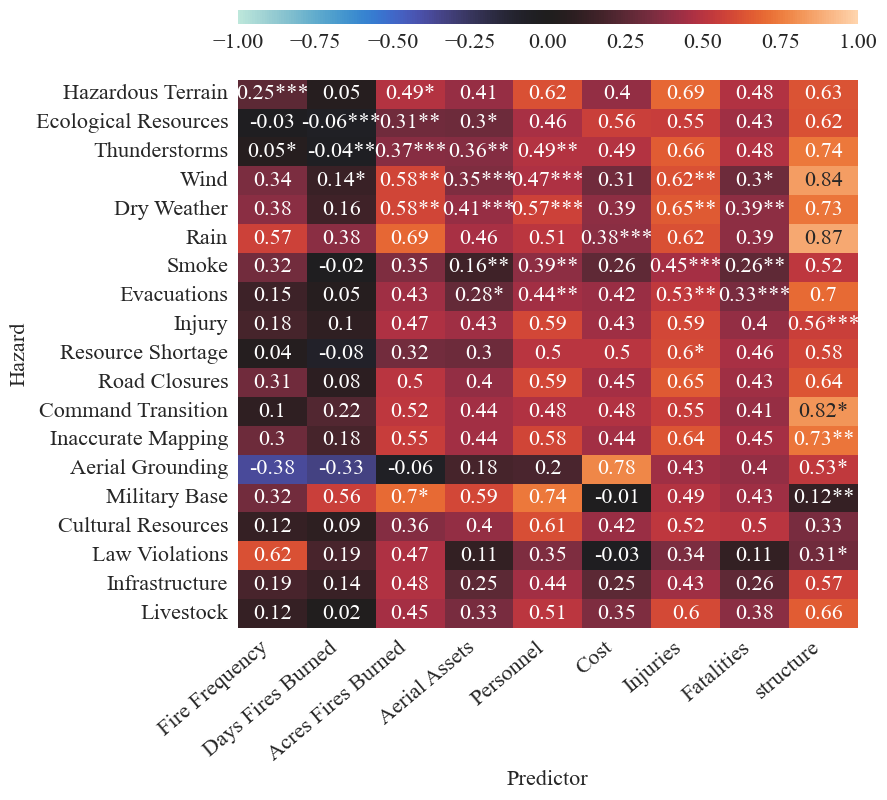

In [84]:
predictors = [p for p in totals_new]
hazards = [h for h in fire_freqs_scaled]
reshape_correlation_matrix(corrMatrix_fires, p_values, predictors, hazards)

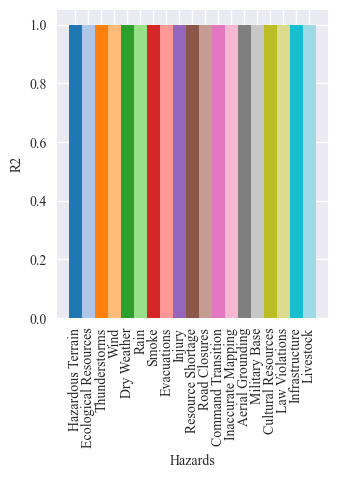

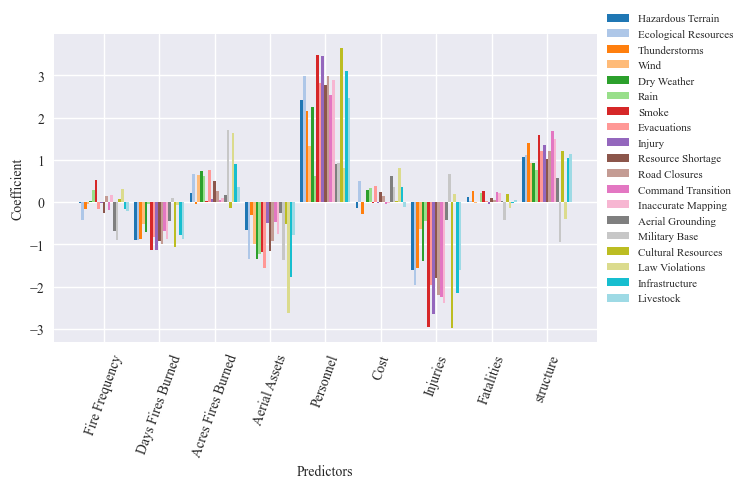

,hazard,R2 for full model,MSE for full model,Fire Frequency removed score,total Days Fires Burned removed score,total Acres Fires Burned removed score,total Aerial Assets removed score,total Personnel removed score,total Cost removed score,total Injuries removed score,...,total structure removed score,Fire Frequency removed MSE,total Days Fires Burned removed MSE,total Acres Fires Burned removed MSE,total Aerial Assets removed MSE,total Personnel removed MSE,total Cost removed MSE,total Injuries removed MSE,total Fatalities removed MSE,total structure removed MSE
0,Hazardous Terrain,1.0,0.0,0.998,-3.219,0.768,-0.623,-18.478,0.942,-5.249,...,-0.482,0.000,0.338,0.019,0.130,1.562,0.005,0.501,0.003,0.119
1,Ecological Resources,1.0,0.0,0.656,-1.463,-0.201,-2.790,-15.777,0.526,-4.314,...,0.093,0.049,0.354,0.172,0.544,2.409,0.068,0.763,0.000,0.130
2,Thunderstorms,1.0,0.0,0.919,-2.368,0.992,0.703,-11.873,0.782,-4.017,...,-1.165,0.008,0.324,0.001,0.029,1.238,0.021,0.482,0.017,0.208
3,Wind,1.0,0.0,0.994,-0.259,-0.664,-2.116,-3.930,1.000,0.152,...,0.025,0.001,0.119,0.157,0.295,0.466,0.000,0.080,0.000,0.092
4,Dry Weather,1.0,0.0,0.998,-0.988,-0.903,-4.106,-11.762,0.807,-2.505,...,0.132,0.000,0.214,0.205,0.551,1.376,0.021,0.378,0.000,0.094
5,Rain,1.0,0.0,0.775,0.991,-0.465,-3.489,-0.057,0.718,0.612,...,0.369,0.023,0.001,0.147,0.450,0.106,0.028,0.039,0.013,0.063
6,Smoke,1.0,0.0,0.292,-4.610,0.999,-3.227,-31.827,1.000,-16.137,...,-1.675,0.070,0.557,0.000,0.420,3.259,0.000,1.701,0.019,0.265
7,Evacuations,1.0,0.0,0.948,-1.310,-0.745,-4.893,-16.169,0.691,-4.964,...,-0.228,0.006,0.289,0.218,0.737,2.148,0.039,0.746,0.000,0.154
8,Injury,1.0,0.0,0.999,-4.561,0.985,0.284,-31.617,1.000,-13.042,...,-1.001,0.000,0.547,0.001,0.070,3.208,0.000,1.381,0.001,0.197
9,Resource Shortage,1.0,0.0,0.834,-2.396,0.128,-2.615,-17.949,0.861,-4.717,...,-0.018,0.018,0.373,0.096,0.397,2.082,0.015,0.628,0.003,0.112


,hazard,R2 for full model,MSE for full model,Fire Frequency removed score,total Days Fires Burned removed score,total Acres Fires Burned removed score,total Aerial Assets removed score,total Personnel removed score,total Cost removed score,total Injuries removed score,...,total structure removed score,Fire Frequency removed MSE,total Days Fires Burned removed MSE,total Acres Fires Burned removed MSE,total Aerial Assets removed MSE,total Personnel removed MSE,total Cost removed MSE,total Injuries removed MSE,total Fatalities removed MSE,total structure removed MSE
0,Hazardous Terrain,1.0,0.0,0.002,4.219,0.232,1.623,19.478,0.058,6.249,...,1.482,-0.000,-0.338,-0.019,-0.130,-1.562,-0.005,-0.501,-0.003,-0.119
1,Ecological Resources,1.0,0.0,0.344,2.463,1.201,3.790,16.777,0.474,5.314,...,0.907,-0.049,-0.354,-0.172,-0.544,-2.409,-0.068,-0.763,-0.000,-0.130
2,Thunderstorms,1.0,0.0,0.081,3.368,0.008,0.297,12.873,0.218,5.017,...,2.165,-0.008,-0.324,-0.001,-0.029,-1.238,-0.021,-0.482,-0.017,-0.208
3,Wind,1.0,0.0,0.006,1.259,1.664,3.116,4.930,0.000,0.848,...,0.975,-0.001,-0.119,-0.157,-0.295,-0.466,-0.000,-0.080,-0.000,-0.092
4,Dry Weather,1.0,0.0,0.002,1.988,1.903,5.106,12.762,0.193,3.505,...,0.868,-0.000,-0.214,-0.205,-0.551,-1.376,-0.021,-0.378,-0.000,-0.094
5,Rain,1.0,0.0,0.225,0.009,1.465,4.489,1.057,0.282,0.388,...,0.631,-0.023,-0.001,-0.147,-0.450,-0.106,-0.028,-0.039,-0.013,-0.063
6,Smoke,1.0,0.0,0.708,5.610,0.001,4.227,32.827,0.000,17.137,...,2.675,-0.070,-0.557,-0.000,-0.420,-3.259,-0.000,-1.701,-0.019,-0.265
7,Evacuations,1.0,0.0,0.052,2.310,1.745,5.893,17.169,0.309,5.964,...,1.228,-0.006,-0.289,-0.218,-0.737,-2.148,-0.039,-0.746,-0.000,-0.154
8,Injury,1.0,0.0,0.001,5.561,0.015,0.716,32.617,0.000,14.042,...,2.001,-0.000,-0.547,-0.001,-0.070,-3.208,-0.000,-1.381,-0.001,-0.197
9,Resource Shortage,1.0,0.0,0.166,3.396,0.872,3.615,18.949,0.139,5.717,...,1.018,-0.018,-0.373,-0.096,-0.397,-2.082,-0.015,-0.628,-0.003,-0.112


,Hazardous Terrain,Ecological Resources,Thunderstorms,Wind,Dry Weather,Rain,Smoke,Evacuations,Injury,Resource Shortage,Road Closures,Command Transition,Inaccurate Mapping,Aerial Grounding,Military Base,Cultural Resources,Law Violations,Infrastructure,Livestock
Fire Frequency,-0.026710,-0.434907,-0.172281,-0.044706,0.030674,0.294113,0.518757,-0.157628,-0.022735,-0.264684,0.154315,-0.196994,0.155867,-0.679722,-0.892195,0.068827,0.304387,-0.154814,-0.205733
Days Fires Burned,-0.887679,-0.907474,-0.868228,-0.526449,-0.706361,-0.045041,-1.138592,-0.820146,-1.128467,-0.932083,-0.993370,-0.674310,-0.885755,-0.447021,0.100759,-1.062265,-0.068719,-0.781091,-0.883145
Acres Fires Burned,0.218366,0.664421,-0.044154,0.634500,0.724769,0.612986,0.019111,0.747378,0.060722,0.495242,0.256264,0.051919,0.083995,0.171237,1.698509,-0.146490,1.626812,0.896498,0.357554
Aerial Assets,-0.659419,-1.348238,-0.308950,-0.991925,-1.356072,-1.225549,-1.183809,-1.569110,-0.484941,-1.151817,-0.922921,-0.480188,-0.766777,-0.254556,-1.363317,-0.513679,-2.631943,-1.780378,-0.770022
Personnel,2.408827,2.991060,2.143770,1.315660,2.260642,0.627199,3.478669,2.824167,3.451628,2.780700,2.986533,2.532783,2.898649,0.895393,0.917536,3.639132,0.803142,3.103003,2.462551
Cost,-0.132613,0.508451,-0.282524,-0.006252,0.281038,0.327950,-0.011527,0.383307,-0.011801,0.241353,0.134572,-0.055549,-0.021726,0.615493,0.366185,0.016190,0.804696,0.359965,-0.120391
Injuries,-1.601518,-1.975918,-1.571002,-0.640381,-1.390647,-0.445877,-2.950252,-1.953818,-2.658327,-1.792774,-2.208000,-2.241003,-2.383291,-0.432888,0.656517,-2.989975,0.195391,-2.159981,-1.613143
Fatalities,0.111248,0.031103,0.252046,-0.017979,-0.010848,0.222284,0.272664,0.033852,-0.044206,0.099170,0.057863,0.232096,0.224665,0.016528,-0.413534,0.192506,-0.140251,-0.013458,0.044595
structure,1.055031,1.103966,1.395890,0.928990,0.936069,0.769336,1.576520,1.198997,1.357454,1.023104,1.219264,1.675715,1.500671,0.579354,-0.956481,1.220021,-0.399779,1.051994,1.131003


In [85]:
predictors = [p for p in totals_new]
hazards = [h.replace("total ","") for h in fire_freqs_scaled]
results_df, delta_df, coefficient_df = multiple_reg_feature_importance(predictors, hazards, correlation_mat_total_fires)
display(results_df, delta_df, coefficient_df)

## Colinearity

In [86]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [87]:
vif_data = pd.DataFrame()
input_df = pd.DataFrame({predictor:totals_new[predictor] for predictor in totals_new})
vif_data["feature"] = input_df.columns
vif_data["VIF"] = [variance_inflation_factor(input_df.values, i)
                          for i in range(len(input_df.columns))]
vif_data

,feature,VIF
0,Fire Frequency,10.545422
1,total Days Fires Burned,98.508631
2,total Acres Fires Burned,318.148035
3,total Aerial Assets,47.954849
4,total Personnel,215.555330
5,total Cost,21.487662
6,total Injuries,187.177715
7,total Fatalities,80.066638
8,total structure,54.806470


In [88]:
vif_data = pd.DataFrame()
input_df = pd.DataFrame({predictor:combined_predictors_scaled[predictor] for predictor in combined_predictors_scaled})
vif_data["feature"] = input_df.columns
vif_data["VIF"] = [variance_inflation_factor(input_df.values, i)
                          for i in range(len(input_df.columns))]
vif_data

,feature,VIF
0,Fire Characteristics,3.984066
1,Operations,17.004590
2,Intensity,13.810379


In [89]:
sums = []
for col in input_df:
    temp_input = input_df.drop(col, axis=1)
    vif_data = pd.DataFrame()
    vif_data["feature"] = temp_input.columns
    vif_data["VIF"] = [variance_inflation_factor(temp_input.values, i)
                          for i in range(len(temp_input.columns))]
    sum_vif = sum(vif_data["VIF"].tolist())
    sums.append(sum_vif)
    display(col,sum_vif, vif_data)
print(min(sums), sums.index(min(sums)), predictors[sums.index(min(sums))])

'Fire Characteristics'

27.612735626886067

,feature,VIF
0,Operations,13.806368
1,Intensity,13.806368


'Operations'

6.469486432284111

,feature,VIF
0,Fire Characteristics,3.234743
1,Intensity,3.234743


'Intensity'

7.96581799128896

,feature,VIF
0,Fire Characteristics,3.982909
1,Operations,3.982909


6.469486432284111 1 total Days Fires Burned


In [90]:
# to_drop = ["total Acres Fires Burned", "total Personnel", "total Injuries", "total Aerial Assets", "total Cost"]#,"total Days Fires Burned"]
# temp_input = input_df.drop(to_drop, axis=1)
# vif_data = pd.DataFrame()
# vif_data["feature"] = temp_input.columns
# vif_data["VIF"] = [variance_inflation_factor(temp_input.values, i)
#                       for i in range(len(temp_input.columns))]
# sum_vif = sum(vif_data["VIF"].tolist())
# display(sum_vif, vif_data)